## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from random import sample  
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.applications.resnet import ResNet50 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Using TensorFlow backend.


Num GPUs Available:  1


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
41015,00010621_000.png,No Finding,0,10621,60,F,PA,2048,2500,0.168,0.168,NaN,/data/images_005/images/00010621_000.png
44896,00011544_017.png,Infiltration,17,11544,52,M,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00011544_017.png
99458,00026320_003.png,Atelectasis,3,26320,51,F,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00026320_003.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
# To do

# Split labels by the delimiter
comorbid_diseases = all_xray_df['Finding Labels'].str.split('|').explode().unique()
print(comorbid_diseases)

for comorbid_disease in comorbid_diseases:
    all_xray_df[comorbid_disease] = all_xray_df['Finding Labels'].str.contains(comorbid_disease).astype(int)

all_xray_df.head(5)

['Cardiomegaly' 'Emphysema' 'Effusion' 'No Finding' 'Hernia'
 'Infiltration' 'Mass' 'Nodule' 'Atelectasis' 'Pneumothorax'
 'Pleural_Thickening' 'Pneumonia' 'Fibrosis' 'Edema' 'Consolidation']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
# To do

# Now, create the 'pneumonia_class' column based on the presence of 'Pneumonia' in the 'Finding Labels' column
all_xray_df['pneumonia_class'] = all_xray_df['Finding Labels'].str.contains('Pneumonia').astype(str)

[Text(0, 0.5, 'Number of Images with Label')]

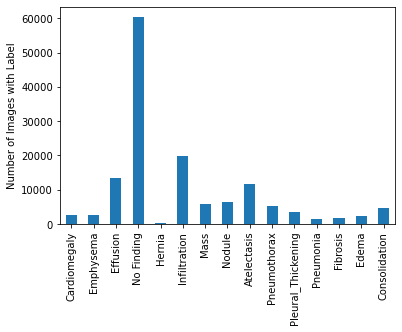

In [5]:
ax = all_xray_df[comorbid_diseases].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

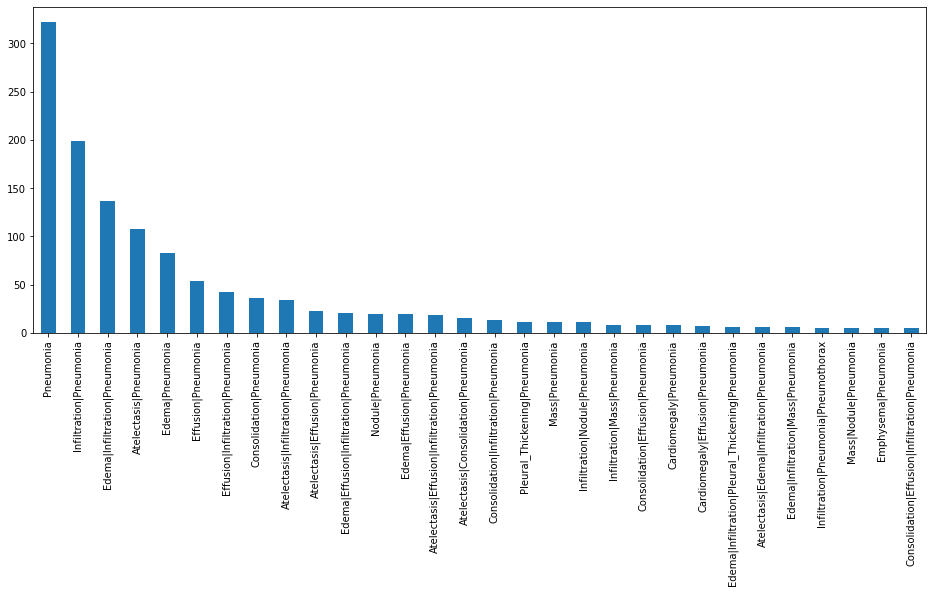

In [6]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

(array([615., 811.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  2.,  43.,  84., 125., 166., 207., 248., 289., 330., 371., 412.]),
 <a list of 10 Patch objects>)

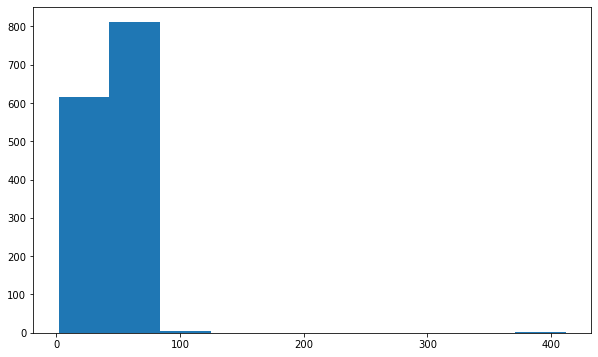

In [7]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'])

## Create your training and testing data:

In [5]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = train_test_split(df, test_size=0.2, stratify = df['Pneumonia'], random_state=42)
    
    return train_data, val_data

# Use the function
train_data, val_data = create_splits(all_xray_df)

# Displaying the shapes of the resulting dataframes for verification
print("Train Data:", train_data.shape)
print("Validation Data:", val_data.shape)

Train Data: (89696, 29)
Validation Data: (22424, 29)


In [6]:
print(train_data['Pneumonia'].sum()/len(train_data)*100)
print(val_data['Pneumonia'].sum()/len(val_data)*100)

1.2765340706386015
1.2754191937210133


Great, our train_test_split made sure that we had the same proportions of Pneumothorax in both sets!

### Condition 1 - To have _EQUAL_ amount of positive and negative cases of Pneumothorax in Training 
But.... we know that we want our model to be trained on a set that has _equal_ proportions of pneumothorax and no pneumothorax, so we're going to have to throw away some data:

In [7]:
p_inds = train_data[train_data.Pneumonia==1].index.tolist()
np_inds = train_data[train_data.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_data = train_data.loc[p_inds + np_sample]

In [8]:
train_data['Pneumonia'].sum()/len(train_data)

0.5

Ta-da! We randomly chose a set of non-Pneumothorax images using the sample() function that was the same length as the number of true Pneumothorax cases we had, and then we threw out the rest of the non-Pneumothorax cases. Now our training dataset is balanced 50-50.

### Condition 2 - To have 20% positive cases of Pneumothorax in the Test Set
Finally, we want to make the balance in our validation set more like 20-80 since our exercise told us that the prevalence of Pneumothorax in this clinical situation is about 20%:

In [9]:
p_inds = val_data[val_data.Pneumonia==1].index.tolist()
np_inds = val_data[val_data.Pneumonia==0].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
val_data = val_data.loc[p_inds + np_sample]

In [10]:
val_data['Pneumonia'].sum()/len(val_data)

0.2

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [11]:
IMG_SIZE = (224, 224)
idg_train = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

idg_val = ImageDataGenerator(rescale=1. / 255.0)

train_gen = idg_train.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9
                                         )

val_gen = idg_val.flow_from_dataframe(dataframe=val_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9
                                         )

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [30]:
batch_size = 9

# Initialize sums and squares sums for 3 channels
channel_sums = np.zeros(3)
channel_squared_sums = np.zeros(3)

for i, (images, labels) in enumerate(train_gen):
    # Important to break after all batches are processed
    if i == n_batches:
        break
    channel_sums += np.sum(images, axis=(0, 1, 2))
    channel_squared_sums += np.sum(np.square(images), axis=(0, 1, 2))

# Compute mean and std
mean = channel_sums / (n_samples * IMG_SIZE[0] * IMG_SIZE[1])  # Multiply by image height and width for average
squared_mean = channel_squared_sums / (n_samples * IMG_SIZE[0] * IMG_SIZE[1])
variance = squared_mean - np.square(mean)
std_dev = np.sqrt(variance)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")


Mean: [0.50952472 0.50952472 0.50952472]
Standard Deviation: [0.24108991 0.24108991 0.24108991]


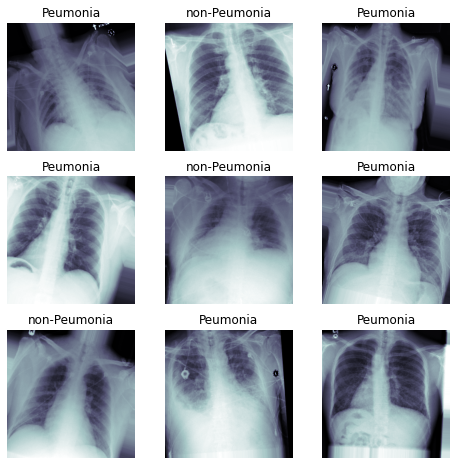

In [15]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(3, 3, figsize = (8, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Peumonia')
    else:
        c_ax.set_title('non-Peumonia')
    c_ax.axis('off')

### Conclusion
- Train-Test split has the appropriate proportion of positive and negative cases. 
- Augment data for the training data only
- Applied augumentation that are appropriate for medical imaging. 
- Normalized the image data so that the model weights do not go to infinity. 

## Now we'll load in VGG16 with pre-trained ImageNet weights: 

Using a pre-trained network downloaded from Keras for fine-tuning

In [15]:
def load_pretrained_model(lay_of_interest='block5_pool'):
    # Todo
    # Load the VGG model including the top (fully connected) layers
    model = VGG16(include_top=True, weights='imagenet')
    
    # Define which layer to use for feature extraction
    transfer_layer = model.get_layer(lay_of_interest)
    
    # Create a new model from the input layer to the layer of interest
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    
    return vgg_model

# To use the function:
vgg_model = load_pretrained_model()
print(vgg_model.summary())

553467904/553467096 [==============================] - 4s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [16]:
## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
## Here, we'll freeze all but the last convolutional layer
for layer in vgg_model.layers[0:15]:
    layer.trainable = False

for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [17]:
def build_my_model(base_model, learning_rate=0.0001):
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model = Sequential()

    # Add the base model (VGG16 without top layers, for instance)
    my_model.add(base_model)

    # Flatten the output of the base model to 1 dimension
    my_model.add(Flatten())
    
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))

    # Add a dense layer(aka. fully-connected)  with some dropout for regularization
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    
    my_model.add(Dense(256, activation='relu'))
        
    # Add the final classification layer - binary in our case
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))

    # Compile the model with a binary crossentropy loss for a binary classification problem
    my_model.compile(optimizer=Adam(learning_rate=learning_rate), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

# Using the function:
model = build_my_model(vgg_model)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [17]:
## Just run a single epoch to see how it does:
model.fit_generator(train_gen, validation_data = (t_x, t_y), epochs = 1)

Epoch 1/1
255/255 [==============================] - 73s 288ms/step - loss: 0.7844 - accuracy: 0.5039 - val_loss: 0.6835 - val_accuracy: 0.4444


In [18]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]



# Name of the file to save the model's weights.
weight_path="{}_my_model.best.hdf5".format('xray_class2')

# Save the model weights when validation accuracy improves.
checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# Stop training when validation accuracy stops improving.
early = EarlyStopping(monitor='val_accuracy', 
                      mode='max', 
                      patience=10)

callbacks_list = [checkpoint, early]


In [19]:
# Save model
model_path = "full_model2.h5"
model.save(model_path)

### Start training! 

In [ ]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)
NUMBER_OF_EPOCHS = 30

model.load_weights(weight_path)
history = model.fit_generator(train_gen, 
          validation_data=val_gen, 
          epochs=NUMBER_OF_EPOCHS, 
          callbacks=callbacks_list)

Epoch 1/30
255/255 [==============================] - 101s 397ms/step - loss: 0.7145 - accuracy: 0.5140 - val_loss: 0.7039 - val_accuracy: 0.2014

Epoch 00001: val_accuracy improved from -inf to 0.20140, saving model to xray_class2_my_model.best.hdf5
Epoch 2/30
255/255 [==============================] - 89s 348ms/step - loss: 0.6907 - accuracy: 0.5393 - val_loss: 0.6361 - val_accuracy: 0.6965

Epoch 00002: val_accuracy improved from 0.20140 to 0.69650, saving model to xray_class2_my_model.best.hdf5
Epoch 3/30
255/255 [==============================] - 88s 345ms/step - loss: 0.6845 - accuracy: 0.5681 - val_loss: 0.6332 - val_accuracy: 0.5804

Epoch 00003: val_accuracy did not improve from 0.69650
Epoch 4/30
255/255 [==============================] - 93s 363ms/step - loss: 0.6753 - accuracy: 0.5969 - val_loss: 0.5697 - val_accuracy: 0.6427

Epoch 00004: val_accuracy did not improve from 0.69650
Epoch 5/30
255/255 [==============================] - 90s 351ms/step - loss: 0.6681 - accuracy

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [12]:
from tensorflow.keras.models import load_model
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

model = load_model("full_model2.h5")
model.load_weights("{}_my_model.best.hdf5".format('xray_class2'))
#pred_Y = model.predict(val_gen, batch_size = 32, verbose = True)
pred_Y = model.predict(val_gen, verbose = True)

159/159 [==============================] - 36s 224ms/step


In [13]:
def plot_auc(t_y, p_y):
     ## Hint: can use scikit-learn's built in functions here like roc_curve
    ## what other performance statistics do you want to include here besides AUC? 
    fpr, tpr, _ = roc_curve(t_y, p_y)
    auc_val = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc_val)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return

def plot_history(history):
    plt.figure(figsize=(12, 4))
    #Also consider plotting the history of your model training:
    # Plotting the training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting the training loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


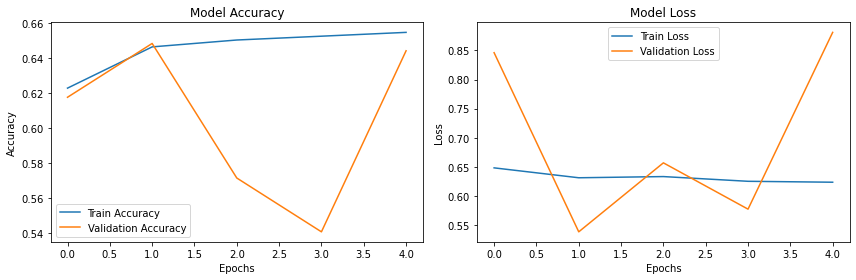

In [25]:
# Plot
# plot_history(history)

In [ ]:
# Plot
plot_history(history)

In [14]:
# Initialize lists to store X and Y values
Y_vals = []

# The number of batches you need to process to cover all validation samples
# This is computed by taking the ceiling of total number of samples divided by batch size.
num_batches = int(np.ceil(val_gen.samples / val_gen.batch_size))

# Loop over the generator for num_batches times
for _ in range(num_batches):
    X, Y = next(val_gen)
    Y_vals.append(Y)

# Concatenate the batches to get the entire dataset
Y_vals = np.concatenate(Y_vals, axis=0)

print(Y_vals.shape)

(1430,)


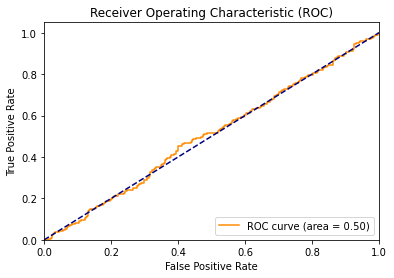

In [15]:
# Plot
#true_labels = val_data['Pneumonia'].values
#true_labels_ = val_data['pneumonia_class'].values
#print(len(true_labels), len(true_labels_))
#print(true_labels[0:100], true_labels_[0:100], Y_vals[0:100])
true_labels = Y_vals
#print(true_labels[0:100], pred_Y[0:100])
plot_auc(true_labels, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [16]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
# The true positive rates (TPR), false positive rates (FPR), and thresholds:
fpr, tpr, thresholds = roc_curve(true_labels, pred_Y)

#Compute Youden's J statistic:
#J = Sensitivity + Specificity - 1 = TPR - FPR
#Find the threshold that maximizes this statistic.
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]
print("optimal_threshold", optimal_threshold)

# Use Optimal Threshold for Binary Classification:
binary_predictions = np.where(pred_Y > optimal_threshold, 1, 0)
print(pred_Y[0:10], binary_predictions[0:10])


# Evaluate Metrics Using the Optimal Threshold: 
# Check the performance of your model with the new binary predictions using various metrics.

accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)
print("===============================")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

optimal_threshold 0.44483218
[[0.5587645 ]
 [0.46057373]
 [0.6173222 ]
 [0.4325838 ]
 [0.46375427]
 [0.43547207]
 [0.4335409 ]
 [0.5236004 ]
 [0.4606487 ]
 [0.36858007]] [[1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]]
Accuracy: 0.5692
Precision: 0.2184
Recall: 0.4476
F1 Score: 0.2936


In [17]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
# Collect 100 samples
valXs = []
valYs = []
for _ in range(12):  # Since 9 * 12 = 108, which is more than 100
    valX, valY = next(val_gen)
    valXs.append(valX)
    valYs.append(valY)

valXs = np.concatenate(valXs, axis=0)[:100]
valYs = np.concatenate(valYs, axis=0)[:100]

print(valYs[20:30])

[1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


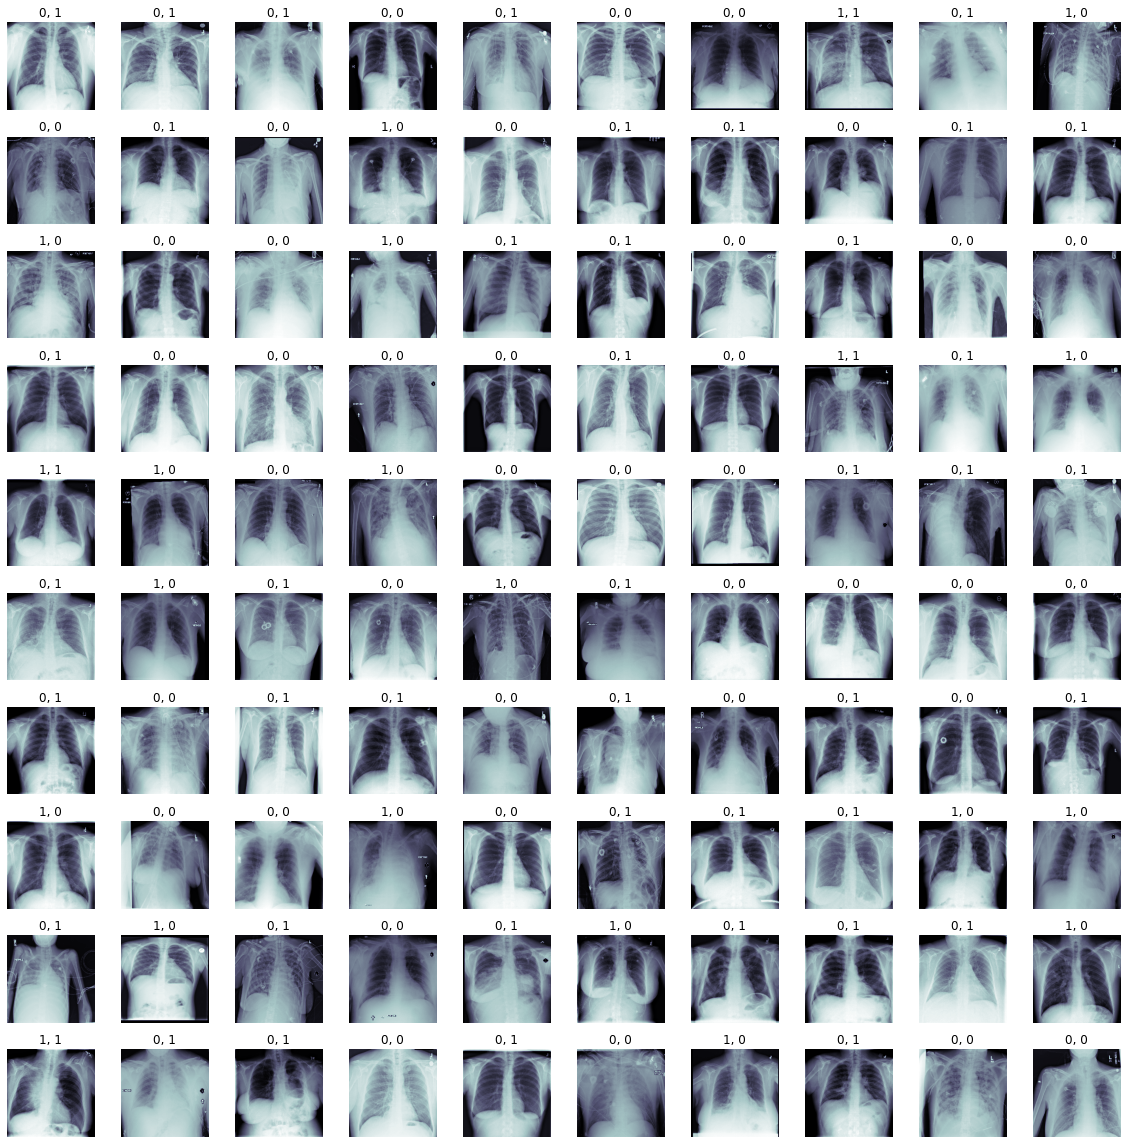

In [18]:
# Assuming valX are your validation images and valY are the true labels for these images.
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0

for (c_x, c_y, c_ax) in zip(valXs[0:100], valYs[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > optimal_threshold:  # replace with your computed threshold
            c_ax.set_title('1, 1')  # True: 1, Predicted: 1
        else:
            c_ax.set_title('1, 0')  # True: 1, Predicted: 0
    else:
        if pred_Y[i] > optimal_threshold:
            c_ax.set_title('0, 1')  # True: 0, Predicted: 1
        else:
            c_ax.set_title('0, 0')  # True: 0, Predicted: 0
    c_ax.axis('off')
    i += 1

plt.tight_layout()
plt.show()

In [19]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model2.json", "w") as json_file:
    json_file.write(model_json)

### Conclusion
- Monitered the training progress of model using log loss
- Changed the parameters to avoid overfitting and compared the performance of different training praradigms. 
- Train enough epochs until the loss is 'stable'
- Used precision, recall, and F1 score to evaluate the utility of model
- Find a threshold to classify if an image is pneumonia or not
- Plotted precision-recall curve and a curve of F-1 Score vs. threshold